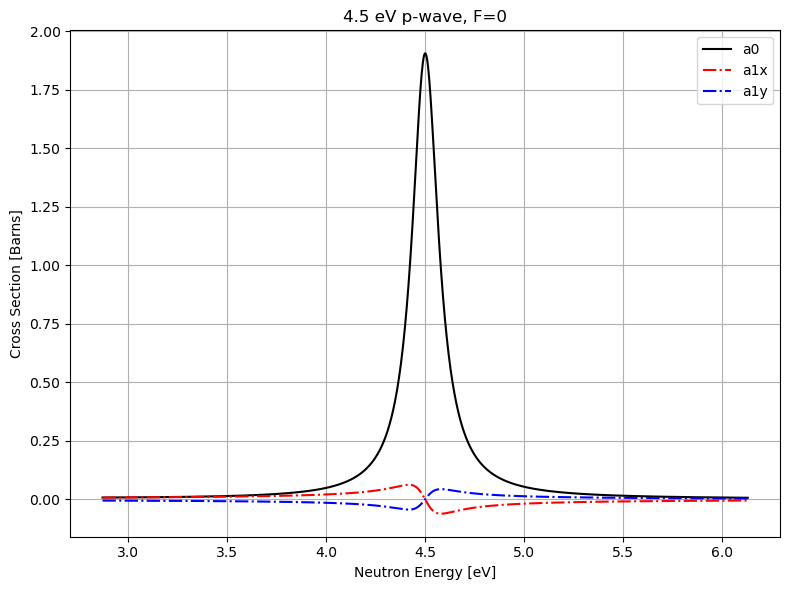

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_6j
from sympy import N
from dataclasses import dataclass
from scipy.integrate import quad


# Constants
mn = 939.56542052e6  # neutron mass eV/c^2
hbarc = 1.973e-7  # hbarc in eV
F = 0  # Final state spin
I = 0.5  # Spin for 111Cd
k = 1

@dataclass
class Resonance:
    E: float
    B: float
    delta_B: float
    l: float
    J: float
    Gn: float
    Gg: float

    @property
    def g(self) -> float:
        # Replace this with the actual formula for the new parameter
        g = (2 * self.J + 1) / 2 / (2 * I + 1)
        return g

    @property
    def Gt(self) -> float:
        # Replace this with the actual formula for the new parameter
        Gt = self.Gn + self.Gg
        return Gt

    @property
    def lambda_r(self) -> float:
        # Replace this with the actual formula for the new parameter
        lambda_r = (
            hbarc
            / 2
            * np.sqrt(
                2 * self.g * self.Gn * self.Gg / mn / np.abs(self.E) / self.Gt / self.Gt
            )
        )
        return lambda_r


def P(j1, j2, j3, j4, j5, j6, j7):
    a = (-1) ** (j1 + j2 + j4 + j6 + j7)
    b = np.sqrt((2 * j1 + 1) * (2 * j2 + 1) * (2 * j3 + 1) * (2 * j4 + 1))
    c = N(wigner_6j(j5, j3, j4, j6, j2, j1))
    d = N(wigner_6j(j5, 1, 1, j7, j1, j2))
    return 3 / 2 * a * b * c * d


def a0(x, p_resonance: Resonance, s_resonances: list[Resonance]):
    Ep = p_resonance.E
    Bp = p_resonance.B
    Gp = p_resonance.Gt
    lambda_p = p_resonance.lambda_r

    a0p = Bp * lambda_p**2 * np.sqrt(x / Ep) * Gp**2 / 4 / ((x - Ep) ** 2 + Gp**2 / 4)
    a0s = 0

    for s_resonance in s_resonances:
        Es = s_resonance.E
        Bs = s_resonance.B
        Gs = s_resonance.Gt
        lambda_s = s_resonance.lambda_r

        a0s += (
            Bs
            * lambda_s**2
            * np.sqrt(np.abs(Es) / x)
            * Gs**2
            / 4
            / ((x - Es) ** 2 + Gs**2 / 4)
        )

    return 1e28 * 2 * np.pi * (a0s + a0p)


def a1x(x, p_resonance: Resonance, s_resonances: list[Resonance]):
    Ep = p_resonance.E
    Bp = p_resonance.B
    Gp = p_resonance.Gt
    Jp = p_resonance.J
    lambda_p = p_resonance.lambda_r
    js = 1 / 2
    jp = 1 / 2

    a1x_val = 0
    for s_resonance in s_resonances:
        Es = s_resonance.E
        Bs = s_resonance.B
        Gs = s_resonance.Gt
        Js = s_resonance.J
        lambda_s = s_resonance.lambda_r

        a = (
            np.sqrt(Bp * Bs)
            * lambda_s
            * lambda_p
            * Gs
            * Gp
            / 2
            * np.power(np.abs(Es) / Ep, 1 / 4)
        )
        num = (x - Es) * (x - Ep) + Gs * Gp / 4
        den = ((x - Es) ** 2 + Gs**2 / 4) * ((x - Ep) ** 2 + Gp**2 / 4)

        a1x_val += a * num / den * P(Js, Jp, js, jp, k, I, F)

    return 1e28 * 2 * np.pi * a1x_val


def a1y(x, p_resonance: Resonance, s_resonances: list[Resonance]):
    Ep = p_resonance.E
    Bp = p_resonance.B
    Gp = p_resonance.Gt
    Jp = p_resonance.J
    lambda_p = p_resonance.lambda_r
    js = 1 / 2
    jp = 3 / 2

    a1x_val = 0
    for s_resonance in s_resonances:
        Es = s_resonance.E
        Bs = s_resonance.B
        Gs = s_resonance.Gt
        Js = s_resonance.J
        lambda_s = s_resonance.lambda_r

        a = (
            np.sqrt(Bp * Bs)
            * lambda_s
            * lambda_p
            * Gs
            * Gp
            / 2
            * np.power(np.abs(Es) / Ep, 1 / 4)
        )
        num = (x - Es) * (x - Ep) + Gs * Gp / 4
        den = ((x - Es) ** 2 + Gs**2 / 4) * ((x - Ep) ** 2 + Gp**2 / 4)

        a1x_val += a * num / den * P(Js, Jp, js, jp, k, I, F)

    return 1e28 * 2 * np.pi * a1x_val


def plot_resonances(p_resonances: list[Resonance], s_resonances: list[Resonance]):
    nrows = int(np.ceil(np.sqrt(len(p_resonances))))
    ncols = int(np.ceil(len(p_resonances) / nrows))

    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 6))

    if len(p_resonances) == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, p_res in enumerate(p_resonances):
        x = np.linspace(p_res.E - 10 * p_res.Gg, p_res.E + 10 * p_res.Gg, 1000)

        a0_vals = a0(x, p_res, s_resonances)
        a1x_vals = a1x(x, p_res, s_resonances)
        a1y_vals = a1y(x, p_res, s_resonances)

        axs[i].plot(x, a0_vals, label="a0", color="black")
        axs[i].plot(x, a1x_vals, label="a1x", color="red", linestyle="-.")
        axs[i].plot(x, a1y_vals, label="a1y", color="blue", linestyle="-.")

        axs[i].set_title(f"{p_res.E} eV p-wave, F={F}")
        axs[i].set_xlabel("Neutron Energy [eV]")
        axs[i].set_ylabel("Cross Section [Barns]")
        axs[i].legend()
        axs[i].grid(True)

    # If there are any unused subplots, remove them
    for j in range(len(p_resonances), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

    # Define the resonance data


p_wave_resonances = [
    Resonance(E=4.5, B=1, delta_B = 0, l=1, J=1, Gn=1.43E-6, Gg=0.163),
]

# s_wave_resonances = [
#     Resonance(E=-4, B=0.01, l=0, J=1, Gn=1.00E-3, Gg=0.068), #jendle
#     Resonance(E=27.57, B=0.02, l=0, J=1, Gn=4.5E-3, Gg=0.096)
# ]

s_wave_resonances = [
    Resonance(E=-4, B=0.037, delta_B=0.026, l=0, J=1, Gn=1.00E-3, Gg=0.068),
    Resonance(E=27.57, B=0, delta_B=0.00014, l=0, J=1, Gn=4.5E-3, Gg=0.096)
]

# s_wave_resonances = [
#     Resonance(E=-4, B=0.04, l=0, J=1, Gn=1.00E-3, Gg=0.068),
#     Resonance(E=27.57, B=0.0004, l=0, J=1, Gn=4.5E-3, Gg=0.096)
# ]

# # Define the resonance data
# p_wave_resonances = [
#     Resonance(E=4.5, B=1, l=1, J=1, Gn=1.43e-6, Gg=0.163),
# ]

# # s_wave_resonances = [
# #     Resonance(E=-27.9, B=0.001, l=0, J=1, Gn=1.873000e-1, Gg=1.290000e-1),
# #     Resonance(E=27.57, B=0.0002, l=0, J=0, Gn=4.912000e-3, Gg=1.311000e-1),
# # ]

# s_wave_resonances = [
#     Resonance(E=-27.9, B=0.106, l=0, J=1, Gn=1.873000e-1, Gg=1.290000e-1), #nndc 
#     Resonance(E=27.57, B=0.0002, l=0, J=0, Gn=4.912000e-3, Gg=1.311000e-1),
# ]

# Plot the resonances
plot_resonances(p_wave_resonances, s_wave_resonances)

In [2]:
p_res = p_wave_resonances[0]
s_res = s_wave_resonances

a0_int_L, error = quad(a0, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a0_int_H, error = quad(a0, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a1x_int_L, error = quad(a1x, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a1x_int_H, error = quad(a1x, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a1y_int_L, error = quad(a1y, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a1y_int_H, error = quad(a1y, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a = (a1x_int_L - a1x_int_H) / (a0_int_L + a0_int_H)
b = (a1y_int_L - a1y_int_H) / (a0_int_L + a0_int_H)


print(f"a = {a:.4f}")
print(f"b = {b:.4f}")

a = 0.0830
b = -0.0587


In [3]:
# Central value calculations for a and b
a0_int_L, _ = quad(a0, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a0_int_H, _ = quad(a0, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a1x_int_L, _ = quad(a1x, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a1x_int_H, _ = quad(a1x, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a1y_int_L, _ = quad(a1y, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a1y_int_H, _ = quad(a1y, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

# Compute central a and b
a_central = (a1x_int_L - a1x_int_H) / (a0_int_L + a0_int_H)
b_central = (a1y_int_L - a1y_int_H) / (a0_int_L + a0_int_H)

print(f"Central value of a: {a_central}")
print(f"Central value of b: {b_central}")


Central value of a: 0.08303841302894922
Central value of b: -0.058717024951739354


In [4]:
# Central value calculations for a and b
a0_int_L, _ = quad(a0, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a0_int_H, _ = quad(a0, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a1x_int_L, _ = quad(a1x, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a1x_int_H, _ = quad(a1x, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

a1y_int_L, _ = quad(a1y, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
a1y_int_H, _ = quad(a1y, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

# Compute central a and b
a_central = (a1x_int_L - a1x_int_H) / (a0_int_L + a0_int_H)
b_central = (a1y_int_L - a1y_int_H) / (a0_int_L + a0_int_H)

print(f"Central value of a: {a_central}")
print(f"Central value of b: {b_central}")

# Function to compute a and b based on B values
def compute_a_b(Bp, Bs_list):
    # Update B values in resonances
    p_res.B = Bp
    for s_resonance, Bs in zip(s_res, Bs_list):
        s_resonance.B = Bs
    
    # Recalculate integrals
    a0_int_L, _ = quad(a0, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
    a0_int_H, _ = quad(a0, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

    a1x_int_L, _ = quad(a1x, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
    a1x_int_H, _ = quad(a1x, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

    a1y_int_L, _ = quad(a1y, p_res.E - 3 * p_res.Gg, p_res.E, args=(p_res, s_res))
    a1y_int_H, _ = quad(a1y, p_res.E, p_res.E + 3 * p_res.Gg, args=(p_res, s_res))

    # Compute a and b
    a_val = (a1x_int_L - a1x_int_H) / (a0_int_L + a0_int_H)
    b_val = (a1y_int_L - a1y_int_H) / (a0_int_L + a0_int_H)
    
    return a_val, b_val


# Central B values
Bp_central = p_res.B
Bs_central = [s_resonance.B for s_resonance in s_res]

# Small change in B to calculate finite difference
delta_B_small = 1e-5  # A small value for finite difference

# Compute a and b for Bp + delta_B
a_plus, b_plus = compute_a_b(Bp_central + delta_B_small, Bs_central)

# Compute a and b for Bp (central value)
a_central, b_central = compute_a_b(Bp_central, Bs_central)

# Calculate partial derivatives (finite differences)
partial_a_Bp = (a_plus - a_central) / delta_B_small
partial_b_Bp = (b_plus - b_central) / delta_B_small

# Repeat for the s-wave resonances
partial_a_Bs = []
partial_b_Bs = []

for i, Bs in enumerate(Bs_central):
    # Increase Bs by delta_B_small
    Bs_perturbed = Bs_central[:]
    Bs_perturbed[i] += delta_B_small

    # Compute a and b for perturbed Bs
    a_plus, b_plus = compute_a_b(Bp_central, Bs_perturbed)
    
    # Calculate partial derivatives for each s-wave resonance
    partial_a_Bs.append((a_plus - a_central) / delta_B_small)
    partial_b_Bs.append((b_plus - b_central) / delta_B_small)


# Propagate uncertainties for a
delta_a = np.sqrt((partial_a_Bp * p_res.delta_B)**2 + sum((partial_a_Bs[i] * s_res[i].delta_B)**2 for i in range(len(s_res))))

# Propagate uncertainties for b
delta_b = np.sqrt((partial_b_Bp * p_res.delta_B)**2 + sum((partial_b_Bs[i] * s_res[i].delta_B)**2 for i in range(len(s_res))))

# Print the results
print(f"a = {a_central:.4f} ± {delta_a:.4f}")
print(f"b = {b_central:.4f} ± {delta_b:.4f}")



Central value of a: 0.08303841302894922
Central value of b: -0.058717024951739354
a = 0.0830 ± 0.0309
b = -0.0587 ± 0.0219
